In [81]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas
import numpy as np
import time 
import itertools

from sklearn.model_selection import train_test_split
from itertools import zip_longest
from Bio.Seq import translate, IUPAC
from torch.nn import functional as F
from scipy.stats import skewnorm
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Reshape, Softmax
from tensorflow.keras import Model
from keras.datasets import mnist
from mpl_toolkits import mplot3d


In [4]:
def f(x, w, b): 
    return np.dot(x, w)  + b 

def make_weights(length):
    return [np.random.random() * 10 for _ in range(length)], np.random.random() * 10

def one_hot_encode_sequence(iterable, mp): 
    result = []
    for x in iterable: 
        result.extend(mp[x])
    return result

def normalize(y): 
    return (y - y.mean()) / y.std()


M, L = 10, 4
w, b = make_weights(M * L)

In [7]:
X = []
cnt = 0
mp = {
    0 : [1, 0, 0, 0],
    1 : [0, 1, 0, 0], 
    2 : [0, 0, 1, 0],
    3 : [0, 0, 0, 1],
}
for x in itertools.product(range(L), repeat=M): 
    seq = one_hot_encode_sequence(x, mp)
    X.append(seq)
    cnt += 1;
assert(cnt == L ** M)
X = np.array(X)
y = np.array([f(x, w, b) for x in X])



In [12]:
print(X[np.argmax(y)], np.argmax(y), np.max(y))
maximal_sequence = X[np.argmax(y)]

[0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 1] 835335 88.47307002042571


In [25]:
def linear_one_hot_solution(w, b): 
    return sum(max(w[i:i + L]) for i in range(0, M * L, L)) + b
assert np.dot(X[np.argmax(y)], w) + b == linear_one_hot_solution(w, b)

In [39]:
samples = 5

y = np.random.random(samples)
print(y)
(y + y) / y

[0.13659412 0.46345229 0.28887948 0.11687155 0.10113206]


array([2., 2., 2., 2., 2.])

In [57]:
def make_2d_values(samples = 1000, sum_range = 10): 
    x = np.random.random(samples) 
    y = np.random.random(samples)
    normalization = [(a + b) / sum_range for a, b in zip(x, y)]
    x = x / normalization
    y = y / normalization 
    return x, y 

def make_3d_values(samples = 100000, sum_range = 10): 
    x = np.random.random(samples) 
    y = np.random.random(samples)
    z = np.random.random(samples)
    normalization = [(a + b + c) / sum_range for a, b, c in zip(x, y, z)]
    x = x / normalization
    y = y / normalization 
    z = z / normalization 
    return x, y, z

def softmax_2d_values(x, y): 
    return np.array([[np.e ** a / (np.e ** a + np.e ** b), np.e ** b / (np.e ** a + np.e ** b)]  for a, b in zip(x, y)])

def softmax_3d_values(x, y, z): 
    return np.array([[np.e ** a / (np.e ** a + np.e ** b + np.e ** c), np.e ** b / (np.e ** a + np.e ** b + np.e ** c), np.e ** c / (np.e ** a + np.e ** b + np.e ** c)]  for a, b, c in zip(x, y, z)])


sum_range = 10
x, y = make_2d_values(sum_range = sum_range)
np.testing.assert_array_almost_equal(sum_range, x + y)
np.testing.assert_almost_equal(np.sum(softmax_2d_values(x, y), axis = -1), 1)
x, y, z = make_3d_values(sum_range = sum_range)
np.testing.assert_array_almost_equal(sum_range, x + y + z)
np.testing.assert_almost_equal(np.sum(softmax_3d_values(x, y, z), axis = -1), 1)



Average distance:  0.7070920356014478


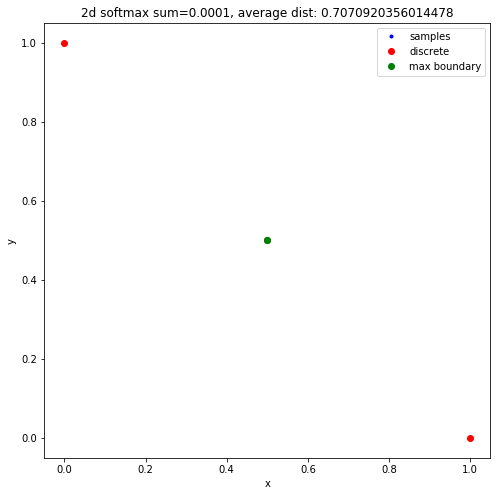

Average distance:  0.7069740243116862


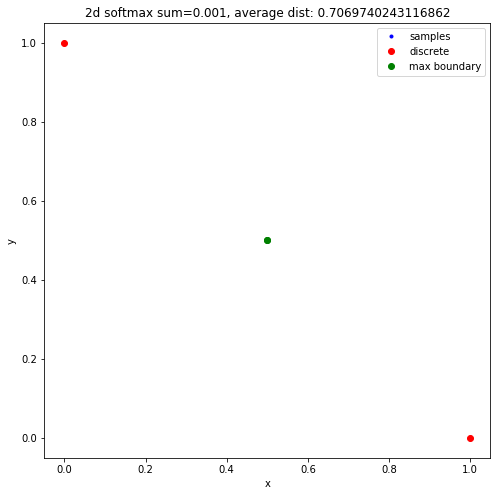

Average distance:  0.7057533507796279


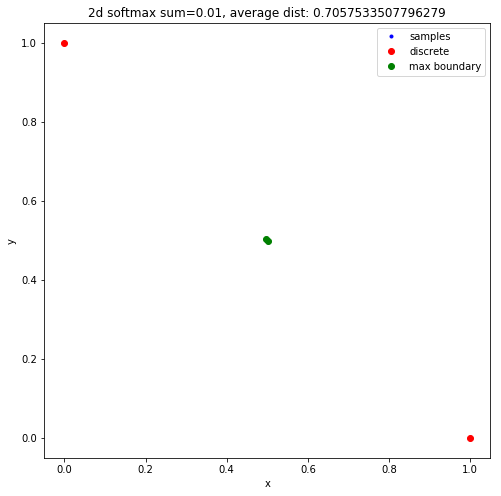

Average distance:  0.6933032588931077


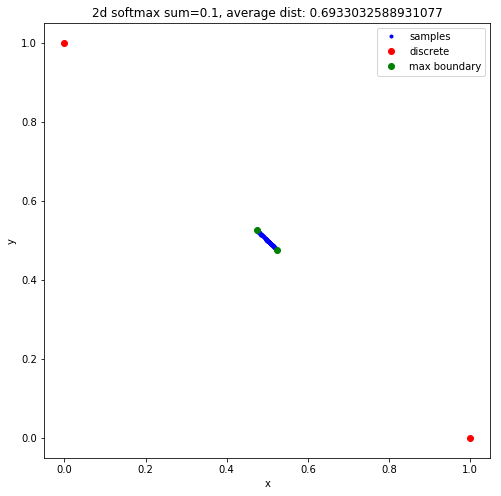

Average distance:  0.5879339712511158


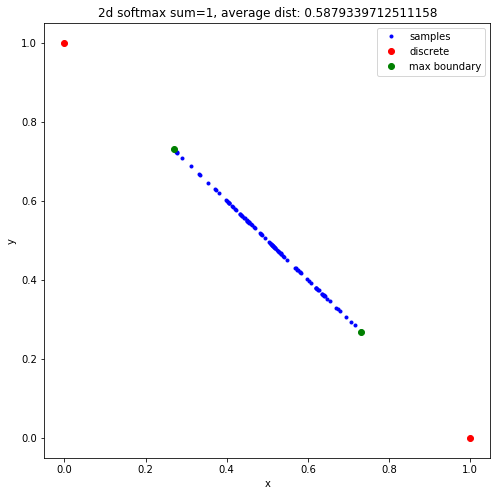

Average distance:  0.5769726807808965


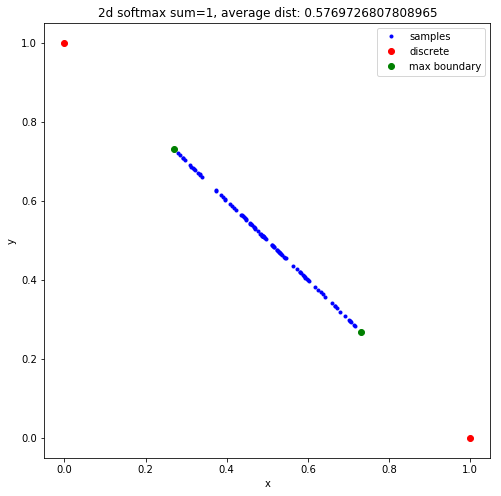

Average distance:  0.15529879982435837


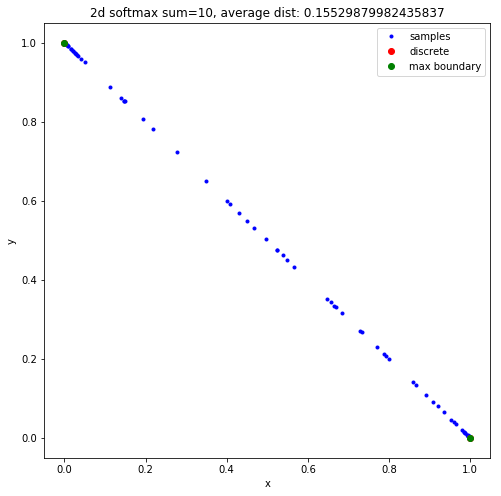

Average distance:  0.009518013224373296


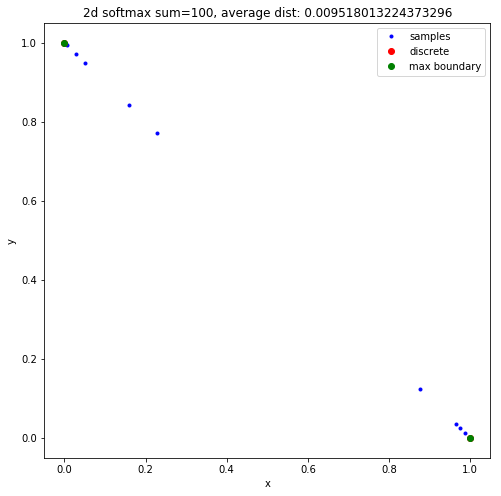

/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


OverflowError: (34, 'Result too large')

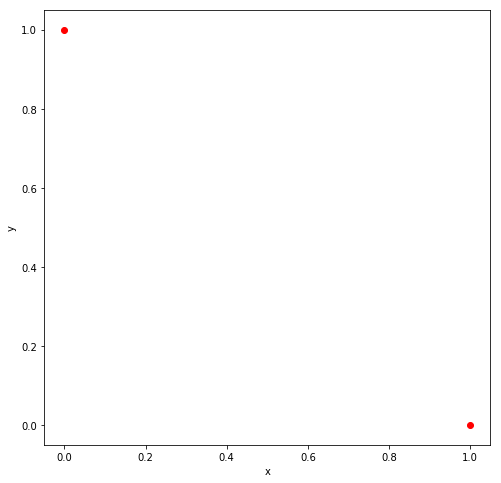

In [149]:
def plot_2d(sum_range, samples, save_fig_dir=None):
    plt.figure(figsize=(8, 8))
    plt.xlabel('x')
    plt.ylabel('y')
    x, y = make_2d_values(sum_range = sum_range, samples = samples)
    array = softmax_2d_values(x, y)
    x, y = array[:, 0], array[:, 1]
    for j in array: 
        np
    plt.plot(x, y, 'bo', label = 'samples', markersize=3)
    # plot boundaries 
    x_d, y_d = np.array([1, 0]), np.array([0, 1]) 
    plt.plot(x_d, y_d, 'ro', label = 'discrete')
    a, b = (np.e ** sum_range)/ (np.e ** sum_range + 1), 1 / (np.e ** sum_range + 1)
    x_b, y_b = [a, b], [b, a]
    dists = [min(np.linalg.norm(x_d - a), np.linalg.norm(y_d - a)) for a in array]
    print("Average distance: ", np.mean(dists))
    plt.title("2d softmax sum={}, average dist: {}".format(sum_range, np.mean(dists)))
    plt.plot(x_b, y_b, 'go', label='max boundary')
    plt.legend()
    if save_fig_dir: 
        plt.savefig(save_fig_dir)
    plt.show()
    return dists
        
for sum_range in [0.0001, 0.001, 0.01, 0.1, 1, 1, 10, 100, 1000]:
    plot_2d(sum_range, 100, "../plots/10_22_2d_softmax_bounds_sum_range_{sum_range}.png")



Average distance:  0.8164911669643229


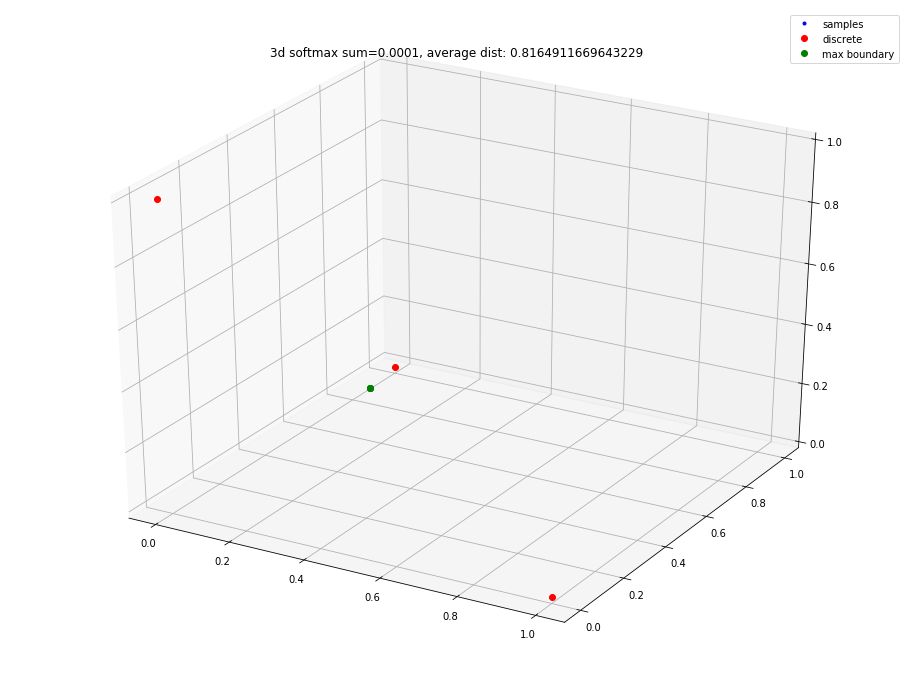

Average distance:  0.8164410983202953


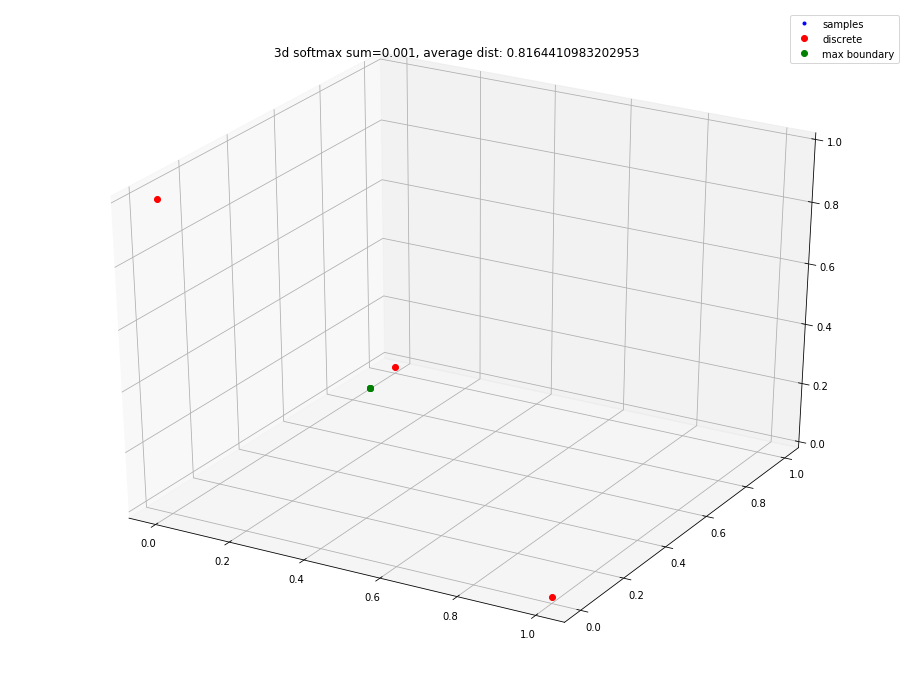

Average distance:  0.8159976899167287


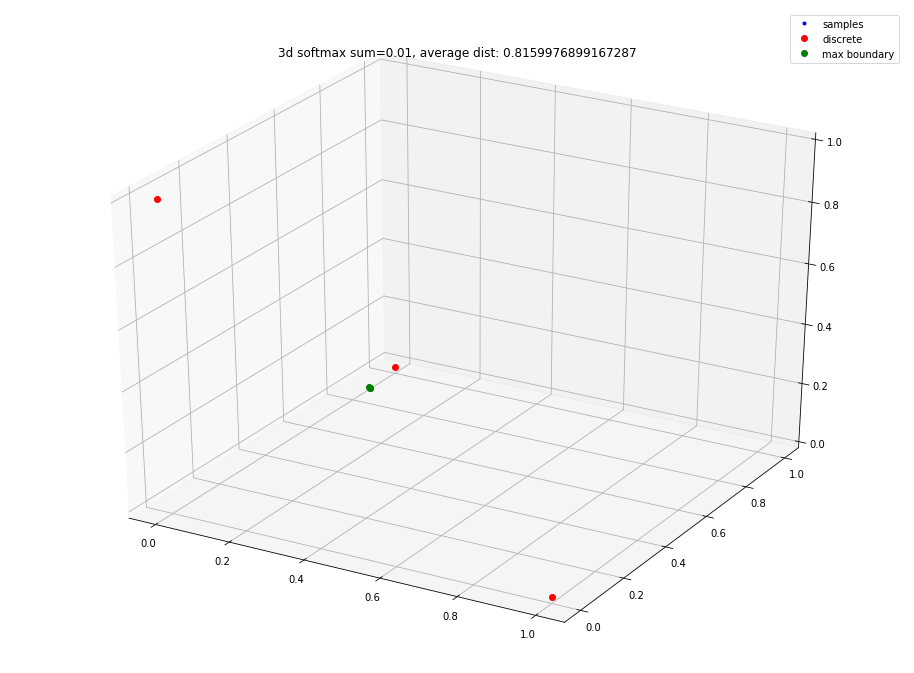

Average distance:  0.8116617855583044


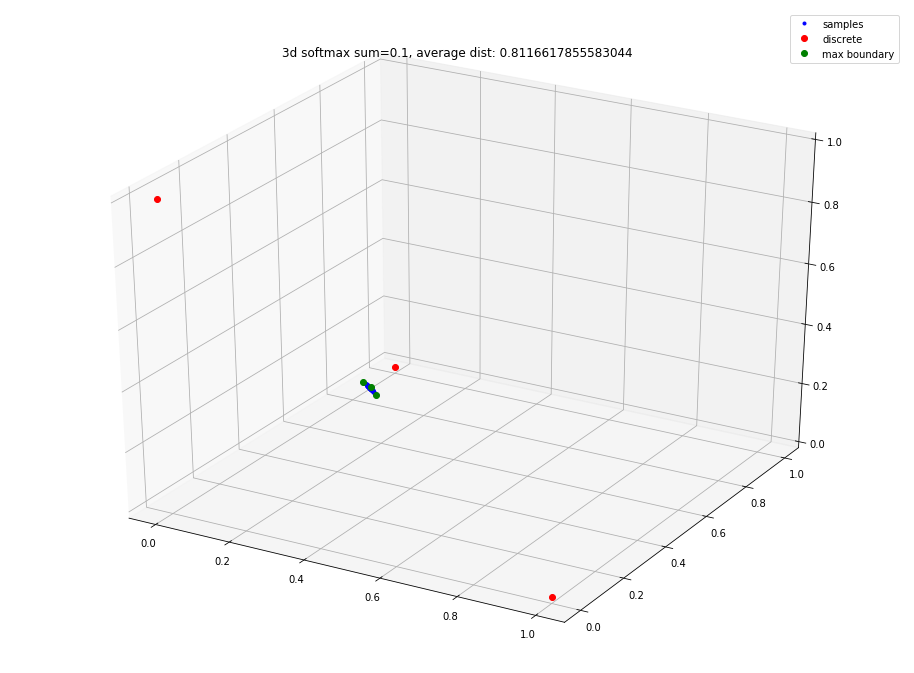

Average distance:  0.7742111275089404


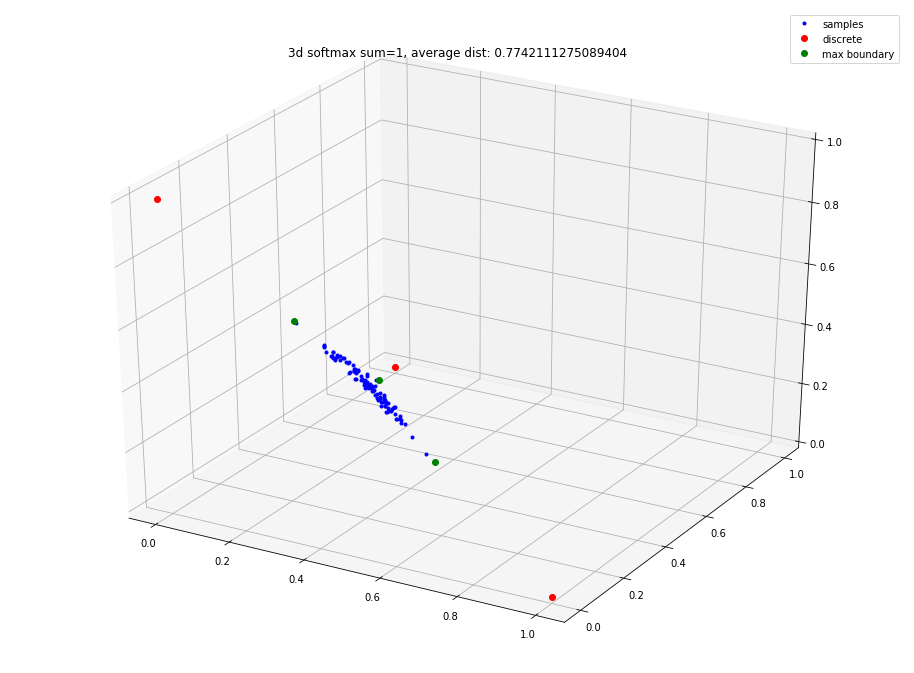

Average distance:  0.7656473540853915


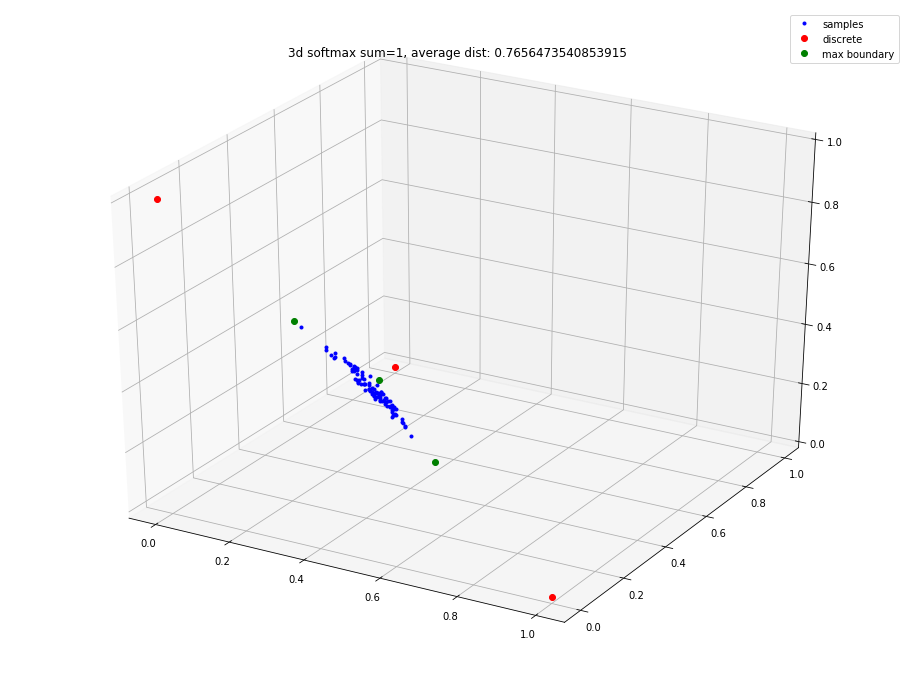

Average distance:  0.5579311115205623


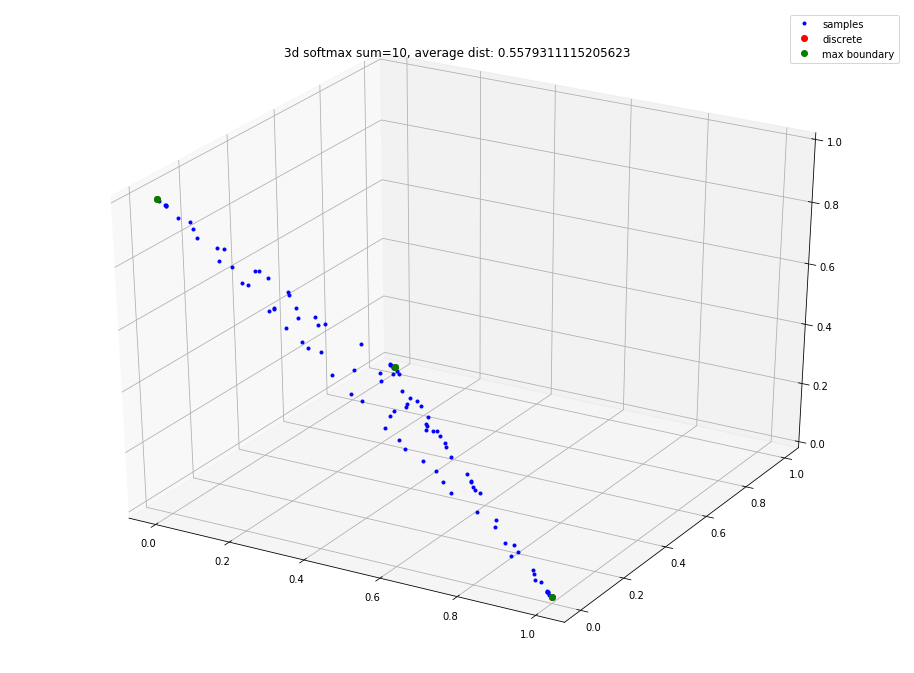

Average distance:  0.5753204218667536


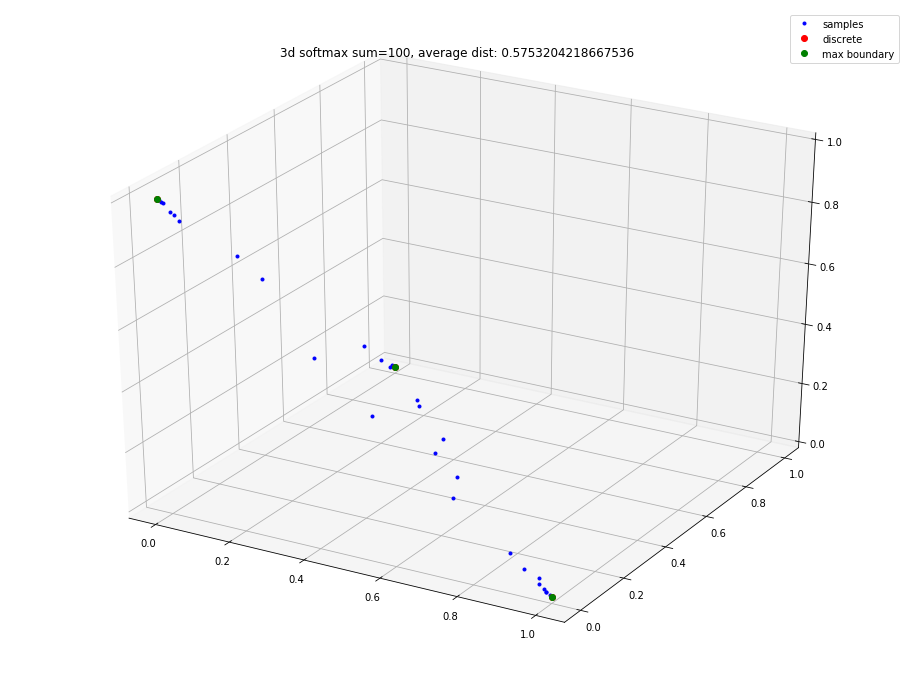

/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


OverflowError: (34, 'Result too large')

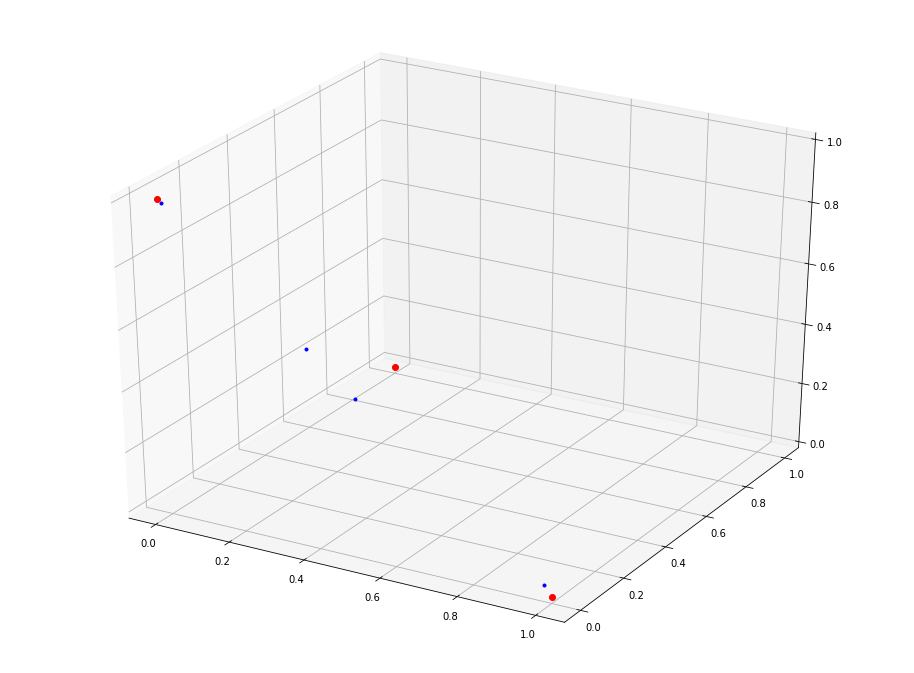

In [150]:
def plot_3d(sum_range, samples, save_fig_dir=None): 
    plt.figure(figsize = (16, 12))
    ax = plt.axes(projection='3d')
    x, y, z = make_3d_values(sum_range = sum_range, samples = samples)
    array = softmax_3d_values(x, y, z)
    x, y, z = array[:, 0], array[:, 1], array[:, 2]
    ax.plot3D(x, y, z, 'bo', label = 'samples', markersize=3)
    x_d, y_d, z_d = np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])
    ax.plot3D(x_d, y_d, z_d, 'ro', label = 'discrete')
    a, b = (np.e ** sum_range) / (np.e ** sum_range + 2), 1 / (np.e ** sum_range + 2)
    x_b, y_b, z_b = [a, b, b], [b, a, b], [b, b, a]
    dists = [min(np.linalg.norm(x_d - a), np.linalg.norm(y_d - a), np.linalg.norm(z_d - 1)) for a in array]
    print("Average distance: ", np.mean(dists))
    plt.title("3d softmax sum={}, average dist: {}".format(sum_range, np.mean(dists)))
    ax.plot3D(x_b, y_b, z_b, 'go', label='max boundary')
    ax.legend()
    if save_fig_dir: 
        plt.savefig(save_fig_dir)
    plt.show()
    
for sum_range in [0.0001, 0.001, 0.01, 0.1, 1, 1, 10, 100, 1000]:
    plot_3d(sum_range, 100, "../plots/10_22_3d_softmax_bounds_sum_range_{sum_range}.png")

